In [2]:
using Revise

In [3]:
using ClimateMARGO # Julia implementation of the MARGO model
using PyPlot # A basic plotting package

┌ Info: Precompiling ClimateMARGO [d3f62095-a717-45bf-aadc-ac9dfc258fa6]
└ @ Base loading.jl:1260


In [4]:
using ClimateMARGO.Models
using ClimateMARGO.Utils
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization

In [5]:
params = deepcopy(ClimateMARGO.IO.included_configurations["default"])
params.economics.ρ = 0.015
params.economics.mitigate_init = nothing
params.economics.remove_init = nothing
params.economics.geoeng_init = nothing
params.economics.adapt_init = nothing

m = ClimateModel(params);

In [6]:
max_slope = Dict("mitigate"=>0., "remove"=>0., "geoeng"=>0., "adapt"=>0.)
max_deployment = Dict("mitigate"=>1.0, "remove"=>1.0, "geoeng"=>0., "adapt"=>0.)
delay_deployment = Dict("mitigate"=>0., "remove"=>0., "geoeng"=>0., "adapt"=>0.)
@time optimize_controls!(m, obj_option = "temp", max_slope=max_slope, max_deployment=max_deployment, delay_deployment=delay_deployment);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 41.001756 seconds (121.98 M allocations: 6.816 GiB, 5.87% gc time)


In [203]:
temp_goals = [1.5, 2.0, 3., 4.0]
Ms = 0.:0.005:1.0
Rs = 0.:0.005:1.0

control_cost = zeros(length(Ms), length(Rs)) .+ 0.
net_benefit = zeros(length(Ms), length(Rs)) .+ 0.
max_temp = zeros(length(Ms), length(Rs)) .+ 0.
min_temp = zeros(length(Ms), length(Rs)) .+ 0.
optimal_controls = zeros(2, length(temp_goals), 2)

for (o, option) = enumerate(["temp", "net_benefit"])
    for (i, M) = enumerate(Ms)
        for (j, R) = enumerate(Rs)
            m.controls.mitigate = zeros(size(t(m))) .+ M
            m.controls.remove = zeros(size(t(m))) .+ R
            m.controls.remove[t(m) .>= 2200.] .= 0.
            if minimum(c(m, M=true, R=true)) <= 100.
                continue
            end
            control_cost[j, i] = net_present_cost(m, discounting=true, M=true, R=true)
            net_benefit[j, i] = net_present_benefit(m, discounting=true, M=true, R=true)
            max_temp[j, i] = maximum(T(m, M=true, R=true))
            min_temp[j, i] = minimum(T(m, M=true, R=true))
        end
    end
    for (g, temp_goal) = enumerate(temp_goals)
        optimize_controls!(m, obj_option = option, temp_goal = temp_goal, max_slope=max_slope, max_deployment=max_deployment, delay_deployment=delay_deployment);
        optimal_controls[:, g, o] = [m.controls.mitigate[1], m.controls.remove[1]]
    end
end

Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded


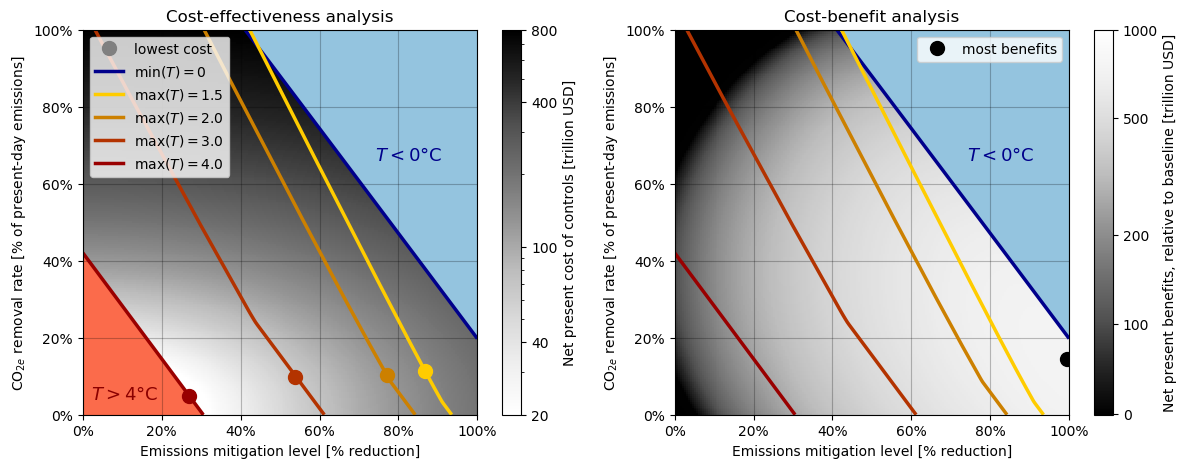

In [229]:
col = ((1., 0.8, 0.), (0.8, 0.5, 0.), (0.7, 0.2, 0.), (0.6, 0., 0.),)

figure(figsize=(14, 5))

o = 1
subplot(1,2,o)
pcolor(Ms, Rs, control_cost, cmap="Greys", norm=matplotlib.colors.LogNorm(vmin=20, vmax=800))
ticks = [20, 40, 100, 400, 800]
cbar = colorbar(label="Net present cost of controls [trillion USD]", ticks=ticks)
cbar.ax.set_yticklabels(ticks)

grid(true, color="k", alpha=0.25)
temp_mask = ones(size(max_temp))
temp_mask[max_temp .<= 4.0] .= NaN
contourf(Ms, Rs, temp_mask, cmap="Reds", alpha=1.0, vmin=0., vmax=2.)

temp_mask = ones(size(min_temp))
temp_mask[min_temp .> 0.] .= NaN
contourf(Ms, Rs, temp_mask, cmap="Blues", alpha=1.0, vmin=0., vmax=2.5)
contour(Ms, Rs, min_temp, colors="darkblue", levels=[0.], linewidths=2.5, label=latexstring("\$\\min(T)=\$", 0))
plot([], [], "o", color="grey", label="lowest cost", markersize=10.)
plot([], [], "-", color="darkblue", label=latexstring("\$\\min(T)=\$", 0), lw=2.5)

for (g, temp_goal) = enumerate(temp_goals)
    contour(Ms, Rs, max_temp, colors=[col[g]], levels=[temp_goal], linewidths=2.5)
    plot(optimal_controls[1,g,o], optimal_controls[2,g,o], "o", color=col[g], markersize=10.)
    plot([], [], "-", color=col[g], label=latexstring("\$\\max(T)=\$", temp_goal), lw=2.5)
end
legend(loc="upper left")

xlabel("Emissions mitigation level [% reduction]")
xticks(0.:0.2:1.0, ["0%", "20%", "40%", "60%", "80%", "100%"])
ylabel(L"CO$_{2e}$ removal rate [% of present-day emissions]")
yticks(0.:0.2:1.0, ["0%", "20%", "40%", "60%", "80%", "100%"])
savefig("test.png", dpi=150.)
annotate(L"$T > 4\degree$C", (0.02, 0.04), xycoords="axes fraction", color="darkred", fontsize=13)
annotate(L"$T < 0\degree$C", (0.74, 0.66), xycoords="axes fraction", color="darkblue", fontsize=13)
title("Cost-effectiveness analysis")

o = 2
subplot(1,2,o)
q = pcolor(Ms, Rs, net_benefit, cmap="Greys_r", norm=matplotlib.colors.SymLogNorm(linthresh=50, linscale=0.01, vmin=-10, vmax=1000))
ticks = [0, 100, 200, 500, 1000]
cbar = colorbar(label="Net present benefits, relative to baseline [trillion USD]", ticks=ticks)
cbar.ax.set_yticklabels(ticks)

grid(true, color="k", alpha=0.25)
temp_mask = ones(size(min_temp))
temp_mask[(min_temp .> 0.)] .= NaN
contourf(Ms, Rs, temp_mask, cmap="Blues", alpha=1.0, vmin=0., vmax=2.5)
contour(Ms, Rs, min_temp, colors="darkblue", levels=[0.], linewidths=2.5)
plot([], [], "-", color="darkblue")

plot(optimal_controls[1,1,2], optimal_controls[2,1,2], "o", color="k", markersize=10., label="most benefits")
for (g, temp_goal) = enumerate(temp_goals)
    contour(Ms, Rs, max_temp, colors=[col[g]], levels=[temp_goal], linewidths=2.5)
end
legend()

xlabel("Emissions mitigation level [% reduction]")
xticks(0.:0.2:1.0, ["0%", "20%", "40%", "60%", "80%", "100%"])
ylabel(L"CO$_{2e}$ removal rate [% of present-day emissions]")
yticks(0.:0.2:1.0, ["0%", "20%", "40%", "60%", "80%", "100%"])
annotate(L"$T < 0\degree$C", (0.74, 0.66), xycoords="axes fraction", color="darkblue", fontsize=13)
title("Cost-benefit analysis")

savefig("../../docs/src/two_dimensional_optimization.png", bbox_inches="tight", dpi=100.)